In [ ]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklego.meta.estimator_transformer import EstimatorTransformer
from scores.probability import crps_cdf
import pandas as pd
from functools import partial

from src.marginal_bootstrap import *

In [75]:
import warnings

warnings.filterwarnings("ignore")

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
sklearn.set_config(enable_metadata_routing=True)

In [78]:
plt.style.use("bmh")

In [219]:
SEED = 42
SAMPLE = 5
BOOTSTRAPS = 5
RUNS = 100

TRUE_MEAN = 0

random_generator = np.random.default_rng(SEED)
sample = random_generator.normal(TRUE_MEAN, 3, SAMPLE)

In [220]:
bootstrap_methods = {
    "non_parametric": bootstrap_non_parametric,
    "bayesian": bootstrap_bayesian,
    "jitter": bootstrap_with_jitter,
    "kde": bootstrap_kde,
}

In [221]:
runs = []
for run in tqdm(range(RUNS)):
    random_generator = np.random.default_rng(run)

    for method_name, method in bootstrap_methods.items():
        bootstraps = method(sample, bootstrap_size=BOOTSTRAPS, random_generator=random_generator)
        assert bootstraps.shape == (SAMPLE, BOOTSTRAPS), f"{method_name} bootstraps shape mismatch"
        result = run, method_name, bootstraps.mean(axis=0)
        runs.append(result)

100%|██████████| 100/100 [00:00<00:00, 366.35it/s]


In [222]:
df = pd.DataFrame(runs, columns=["run", "method", "means"]).explode("means")
df

,run,method,means
0,0,non_parametric,-0.483104
0,0,non_parametric,-1.029734
0,0,non_parametric,2.097981
0,0,non_parametric,0.75628
0,0,non_parametric,-4.759844
...,...,...,...
399,99,kde,1.73736
399,99,kde,-3.670887
399,99,kde,-0.990807
399,99,kde,-0.20582


In [223]:
summary_df = (
    df.groupby(["method", "run"])
    .agg(
        lower=("means", partial(np.quantile, q=0.025)),
        upper=("means", partial(np.quantile, q=0.975)),
    )
    .assign(width=lambda x: x.upper - x.lower)
    .reset_index(drop=False)
)
summary_df

,method,run,lower,upper,width
0,bayesian,0,-0.647124,0.241228,0.888352
1,bayesian,1,-0.441286,0.052884,0.494170
2,bayesian,2,-0.648157,-0.096232,0.551925
3,bayesian,3,-0.433104,-0.065029,0.368075
4,bayesian,4,-0.212027,0.420844,0.632871
...,...,...,...,...,...
395,non_parametric,95,0.114238,1.210928,1.096690
396,non_parametric,96,-3.029626,0.112455,3.142081
397,non_parametric,97,-1.869214,0.598955,2.468169
398,non_parametric,98,-2.544909,0.492254,3.037163


In [224]:
def coverage_count(true_value, lower, upper):
    return np.sum((true_value >= lower) & (true_value <= upper))

In [225]:
def regression_mwi_score(
    y_true,
    lower,
    upper,
    confidence_level: float = 0.95
) -> float:

    y_pis = np.stack([lower, upper]).T[:, :, np.newaxis]
    y_pred_low = np.minimum(y_pis[:, 0, 0], y_pis[:, 1, 0])
    y_pred_up = np.maximum(y_pis[:, 0, 0], y_pis[:, 1, 0])

    width = np.sum(y_pred_up) - np.sum(y_pred_low)  # type: ignore
    error_above = np.sum((y_true - y_pred_up)[y_true > y_pred_up])
    error_below = np.sum((y_pred_low - y_true)[y_true < y_pred_low])
    total_error = error_above + error_below
    mwi = (width + total_error * 2 / (1 - confidence_level)) / len(lower)
    return mwi

In [318]:
def isd_from_kde(samples, grid_size=100):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)
    
    second_deriv = np.gradient(np.gradient(f_vals, dx), dx)
    
    isd = np.sum(np.abs(second_deriv)) * dx
    return isd

def entropy(samples, grid_size=100):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)

    f_norm = f_vals / np.sum(f_vals * dx) 
    return -np.sum(f_norm * np.log(f_norm + 1e-12)) * dx

In [332]:
from scipy import stats
from scores.probability import crps_cdf
import xarray

def cprs(true_value, samples, grid_size=100):
    x = np.linspace(min(samples), max(samples), grid_size)
    fcst_cdf = stats.norm.cdf(x, loc=3)
    fcst_array = xarray.DataArray(coords={'temperature': x}, data=fcst_cdf)
    obs_array = xarray.DataArray(true_value)
    return crps_cdf(fcst_array, obs_array, threshold_dim='temperature').total.values.round(3)

In [334]:
from collections import defaultdict


metrics = defaultdict(list)

for boot in range(RUNS):
    bootstrap_df = summary_df.groupby("method").sample(frac=1, replace=True, random_state=boot)
    bootstrap_with_groups = bootstrap_df.groupby("method")

    coverage_occurrencies = bootstrap_with_groups.apply(lambda x: coverage_count(TRUE_MEAN, x.lower, x.upper))
    coverage_occurrencies_ratio = coverage_occurrencies / RUNS
    metrics["coverage"].append(coverage_occurrencies_ratio)

    mwi = bootstrap_with_groups.apply(lambda x: regression_mwi_score(TRUE_MEAN, x.lower, x.upper))
    metrics["mwi"].append(mwi)

    width = bootstrap_with_groups.apply(lambda x: x.upper - x.lower)
    metrics["width"].append(width)

    lower_std = bootstrap_with_groups.apply(lambda x: np.std(x.lower))
    metrics["lower_std"].append(lower_std)
    
    upper_std = bootstrap_with_groups.apply(lambda x: np.std(x.upper))
    metrics["upper_std"].append(upper_std)
    
    bootstrap_df_samples = df.groupby("method").sample(frac=1, replace=True, random_state=boot)
    bootstrap_df_samples_with_groups = bootstrap_df_samples.groupby("method")
    
    entropy_result = bootstrap_df_samples_with_groups.apply(lambda x: entropy(x.means.astype(np.float64)))
    metrics["entropy"].append(entropy_result)
    
    isd_result = bootstrap_df_samples_with_groups.apply(lambda x: isd_from_kde(x.means.astype(np.float64)))
    metrics["isd"].append(isd_result)
    
    crps_result = bootstrap_df_samples_with_groups.apply(lambda x: cprs(TRUE_MEAN, x.means.astype(np.float64)))
    metrics["crps"].append(crps_result)

In [335]:
metrics_df = pd.concat([pd.concat(metrics[key]).reset_index().assign(metric=key) for key in metrics])

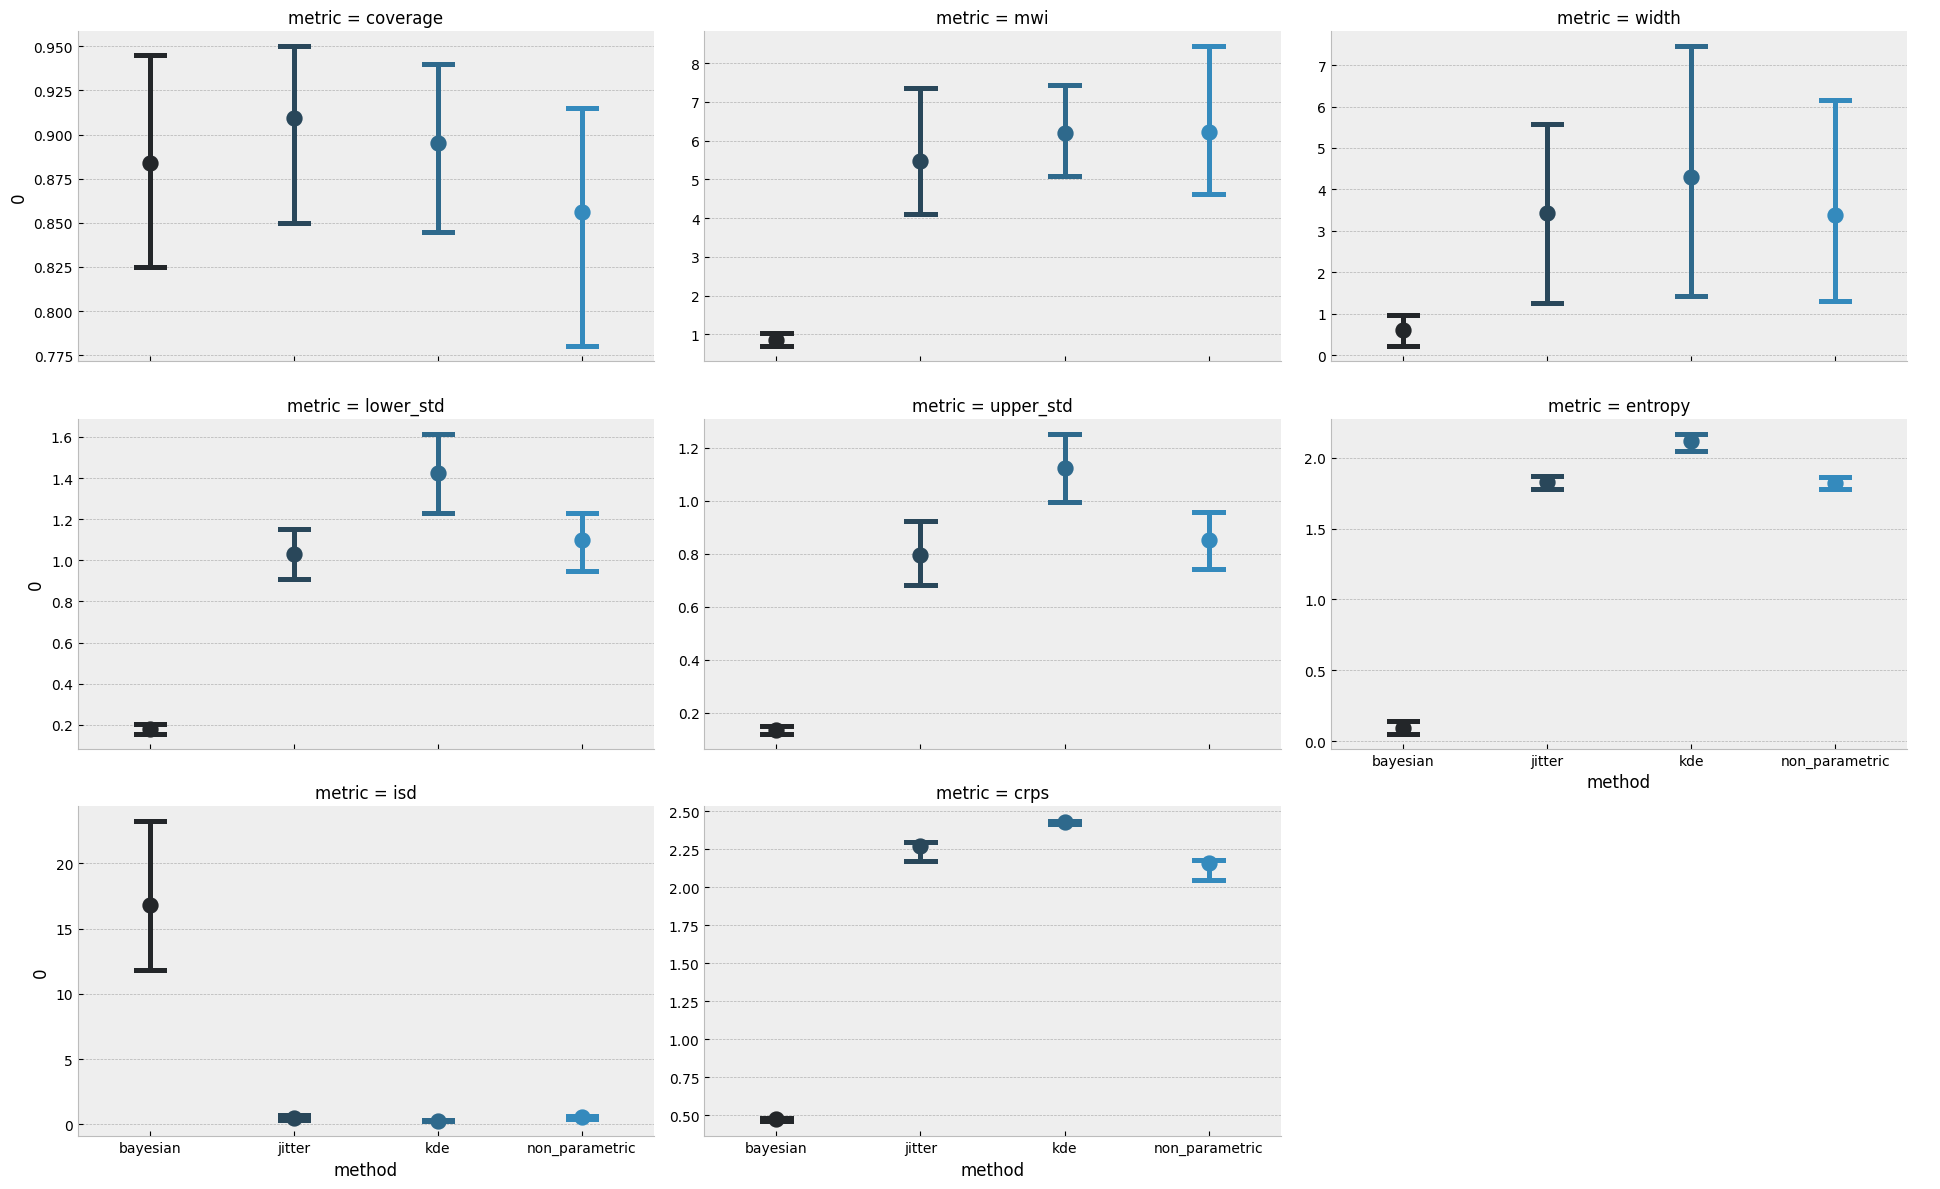

In [336]:
facet = sns.FacetGrid(data=metrics_df, col="metric", height=4, aspect=1.61, sharey=False, col_wrap=3)
facet.map_dataframe(sns.pointplot, data=metrics_df, x="method", hue="method", y=0, join=False, errorbar=("pi", 95), capsize=0.2)
facet.add_legend()

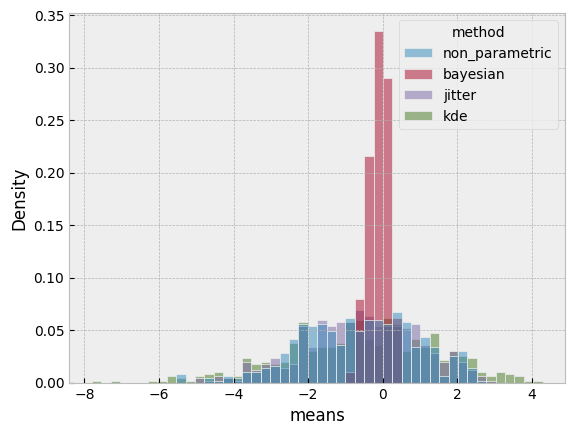

In [282]:
sns.histplot(data=df, x="means", hue="method", stat="density");